In [1]:
import pandas as pd
import numpy as np

X_resampled = np.load("X_resampled.npy")
y_resampled = np.load("y_resampled.npy")
groups_resampled = np.load("groups_resampled.npy")
df_features = pd.read_csv("Features_130.csv", index_col=0)

0it [00:00, ?it/s]


=== Fold 1 ===
Number of features: 1, Accuracy: 51.67%
Number of features: 2, Accuracy: 52.87%
Number of features: 3, Accuracy: 55.50%
Number of features: 4, Accuracy: 56.86%
Number of features: 5, Accuracy: 59.42%
Number of features: 6, Accuracy: 59.32%
Number of features: 7, Accuracy: 60.56%
Number of features: 8, Accuracy: 61.59%
Number of features: 9, Accuracy: 61.47%
Number of features: 10, Accuracy: 61.07%
Number of features: 11, Accuracy: 61.88%
Number of features: 12, Accuracy: 62.76%
Number of features: 13, Accuracy: 61.79%
Number of features: 14, Accuracy: 63.72%
Number of features: 15, Accuracy: 64.26%
Number of features: 16, Accuracy: 64.92%
Number of features: 17, Accuracy: 65.75%
Number of features: 18, Accuracy: 65.66%
Number of features: 19, Accuracy: 66.43%
Number of features: 20, Accuracy: 67.59%
Number of features: 21, Accuracy: 66.46%
Number of features: 22, Accuracy: 67.36%
Number of features: 23, Accuracy: 67.85%
Number of features: 24, Accuracy: 67.52%
Number of

1it [20:38, 1238.01s/it]

Number of features: 130, Accuracy: 69.66%
Processing time for fold 1: 1237.58 seconds

=== Fold 2 ===
Number of features: 1, Accuracy: 51.66%
Number of features: 2, Accuracy: 51.05%
Number of features: 3, Accuracy: 55.38%
Number of features: 4, Accuracy: 56.68%
Number of features: 5, Accuracy: 57.58%
Number of features: 6, Accuracy: 59.63%
Number of features: 7, Accuracy: 59.77%
Number of features: 8, Accuracy: 60.34%
Number of features: 9, Accuracy: 61.38%
Number of features: 10, Accuracy: 61.94%
Number of features: 11, Accuracy: 60.69%
Number of features: 12, Accuracy: 61.40%
Number of features: 13, Accuracy: 61.55%
Number of features: 14, Accuracy: 62.00%
Number of features: 15, Accuracy: 62.73%
Number of features: 16, Accuracy: 63.79%
Number of features: 17, Accuracy: 64.16%
Number of features: 18, Accuracy: 64.00%
Number of features: 19, Accuracy: 64.80%
Number of features: 20, Accuracy: 66.01%
Number of features: 21, Accuracy: 66.05%
Number of features: 22, Accuracy: 67.21%
Numbe

2it [40:52, 1226.41s/it]

Number of features: 130, Accuracy: 69.35%
Processing time for fold 2: 1214.79 seconds

=== Overall Results ===
Mean Accuracies for each number of features: [0.51665156 0.51956673 0.55439856 0.56767453 0.58499191 0.59473624
 0.60164942 0.6096352  0.61425462 0.61504765 0.61284209 0.6207732
 0.6166728  0.62859065 0.63494862 0.64355796 0.64951853 0.64828052
 0.65615645 0.6679704  0.66257643 0.67287268 0.66717902 0.66768956
 0.66724293 0.66696564 0.67714368 0.6732635  0.6737734  0.66944456
 0.6747893  0.67518657 0.67136625 0.67714951 0.67422269 0.67945833
 0.67828095 0.67158304 0.68670702 0.68294011 0.68142139 0.67973157
 0.68575049 0.68254385 0.68630899 0.68417685 0.68294365 0.68446034
 0.69048787 0.68192776 0.68631748 0.68626407 0.68828522 0.69109801
 0.6875494  0.68113689 0.6778185  0.6860393  0.69458282 0.68569797
 0.68868034 0.68586148 0.68777797 0.69278682 0.68833952 0.69002554
 0.68795009 0.6851263  0.68879057 0.68850024 0.68822283 0.68721478
 0.68901256 0.69103966 0.69003162 0.69087

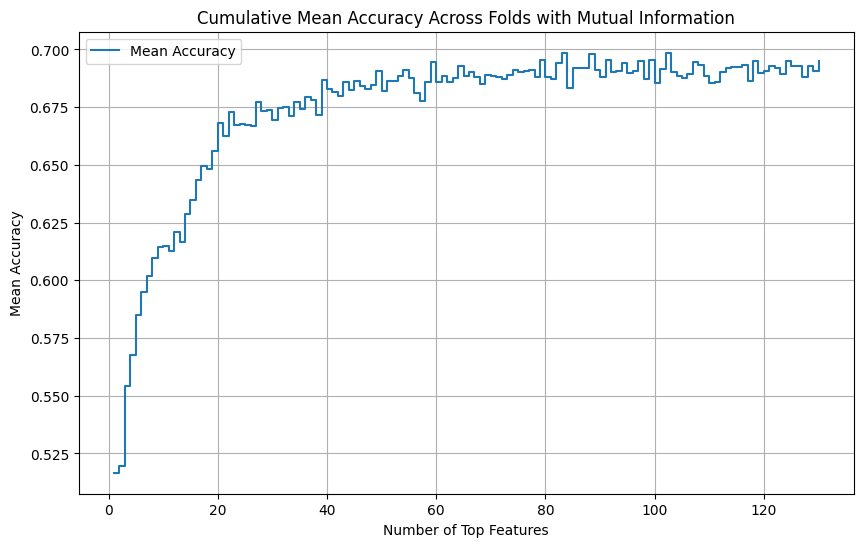

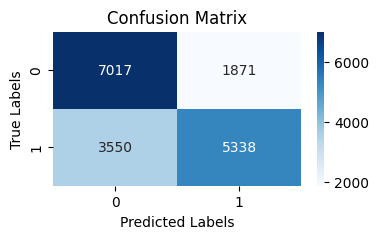

In [2]:
import numpy as np
from collections import Counter
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# Cross-validation setup
sgkf = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=206)  # Use n_splits=5 for optimal value

# Initialize variables
fold_accuracies = []
all_test = []
all_pred = []
feature_score_sums = {}
feature_counts = {}

# Splitting according to CV strategy
for fold_idx, (train_idx, test_idx) in tqdm(enumerate(sgkf.split(X_resampled, y_resampled, groups_resampled))):
    print(f"\n=== Fold {fold_idx + 1} ===")
    start_time = time.time()

    # Split into train and test data
    X_train, y_train = X_resampled[train_idx], y_resampled[train_idx]
    X_test, y_test = X_resampled[test_idx], y_resampled[test_idx]

    # List to store accuracy for each number of features
    accuracies = []
    
    max_features = min(130, X_train.shape[1])
        
    for k in range(1, max_features + 1):
        # Define the pipeline with XGBoost
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selector', SelectKBest(score_func=mutual_info_classif, k=k)),
            ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
        ])

        # Define hyperparameter distributions for XGBoost
        param_distributions = {
            'classifier__n_estimators': randint(100, 500),
            'classifier__max_depth': randint(3, 10),
            'classifier__learning_rate': uniform(0.01, 0.3),
            'classifier__subsample': uniform(0.6, 0.4),
            'classifier__colsample_bytree': uniform(0.6, 0.4),
            'classifier__gamma': uniform(0, 0.5),
            'classifier__reg_alpha': uniform(0, 1),
            'classifier__reg_lambda': uniform(0, 1)
        }

        # Set up RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions,
            n_iter=1,  # Adjust as needed, e.g., 10 for better tuning
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )

        # Fit RandomizedSearchCV
        random_search.fit(X_train, y_train)

        # Get the best pipeline
        best_pipeline = random_search.best_estimator_

        # Get the feature selector
        feature_selector = best_pipeline.named_steps['feature_selector']

        # Get the mutual information scores
        mi_scores = feature_selector.scores_

        # Get the selected feature indices
        selected_features = feature_selector.get_support(indices=True)

        # Get the mi_scores for selected features
        selected_mi_scores = mi_scores[selected_features]

        # Update cumulative scores and counts
        for idx, score in zip(selected_features, selected_mi_scores):
            feature_score_sums[idx] = feature_score_sums.get(idx, 0) + score
            feature_counts[idx] = feature_counts.get(idx, 0) + 1

        # Predict and evaluate
        y_pred = best_pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        print(f"Number of features: {k}, Accuracy: {acc * 100:.2f}%")

    # Store predictions for overall evaluation
    all_test.extend(y_test)
    all_pred.extend(y_pred)
    fold_accuracies.append(accuracies)

    end_time = time.time()
    print(f"Processing time for fold {fold_idx + 1}: {end_time - start_time:.2f} seconds")

# Compute average feature scores
average_feature_scores = []
for feature_idx in feature_score_sums:
    avg_score = feature_score_sums[feature_idx] / feature_counts[feature_idx]
    average_feature_scores.append((feature_idx, avg_score))

# Summary
print("\n=== Overall Results ===")
mean_accuracies = np.mean(fold_accuracies, axis=0)
print("Mean Accuracies for each number of features:", mean_accuracies)

# Plot overall cumulative accuracy across folds
plt.figure(figsize=(10, 6))
plt.step(range(1, max_features + 1), mean_accuracies, where='post', label='Mean Accuracy')
plt.xlabel('Number of Top Features')
plt.ylabel('Mean Accuracy')
plt.title('Cumulative Mean Accuracy Across Folds with Mutual Information')
plt.legend()
plt.grid(True)
plt.show()

# Visualize overall confusion matrix
cm = confusion_matrix(all_test, all_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [3]:
df = pd.DataFrame(average_feature_scores)
average_feature_scores_indices = []
average_feature_scores_list=[]
for i, j in average_feature_scores:
    average_feature_scores_indices.append(i)
average_feature_scores_indices

[21,
 116,
 120,
 118,
 112,
 19,
 114,
 110,
 124,
 90,
 122,
 91,
 126,
 4,
 128,
 97,
 2,
 6,
 48,
 54,
 49,
 55,
 63,
 41,
 40,
 10,
 64,
 83,
 8,
 42,
 9,
 46,
 0,
 3,
 80,
 5,
 43,
 14,
 1,
 92,
 76,
 111,
 82,
 25,
 28,
 24,
 27,
 17,
 101,
 94,
 22,
 36,
 66,
 13,
 95,
 70,
 53,
 52,
 79,
 104,
 47,
 15,
 99,
 12,
 7,
 23,
 16,
 73,
 34,
 78,
 11,
 67,
 117,
 35,
 103,
 57,
 102,
 75,
 86,
 58,
 39,
 106,
 51,
 61,
 93,
 77,
 62,
 105,
 108,
 56,
 38,
 31,
 59,
 44,
 60,
 68,
 74,
 125,
 26,
 37,
 81,
 29,
 129,
 96,
 107,
 45,
 98,
 65,
 87,
 121,
 109,
 88,
 50,
 89,
 113,
 115,
 20,
 30,
 32,
 33,
 69,
 127,
 119,
 123,
 85,
 100,
 84,
 71,
 72,
 18]

In [4]:
for i in average_feature_scores_indices:
    average_feature_scores_list.append(df_features.columns[i])
average_feature_scores_list


['min_fall_slope',
 'dwt_cD4_min',
 'dwt_cD3_min',
 'dwt_cD3_max',
 'dwt_cA4_min',
 'max_rise_slope',
 'dwt_cD4_max',
 'dwt_cA4_max',
 'dwt_cD2_min',
 'min',
 'dwt_cD2_max',
 'max',
 'dwt_cD1_max',
 'iqr_time_diff_onset_dic',
 'dwt_cD1_min',
 'zero_cross',
 'iqr_time_diff_onset_sys',
 'iqr_time_diff_dic_ends',
 'MedianNN',
 'NN50',
 'IQRNN',
 'PNN50',
 'ApEn',
 'bc_duration',
 'ab_duration',
 'pulse_rate',
 'LZC',
 'power_second_harmonic',
 'avg_time_diff_p1_dia',
 'bd_duration',
 'avg_time_diff_p2_dia',
 'Mean_IBI',
 'avg_time_diff_sys_dia',
 'avg_time_diff_onset_dic',
 'LZC_PPG',
 'avg_time_diff_dic_ends',
 'total_wave_duration',
 'avg_reflection_index',
 'avg_time_diff_onset_sys',
 'mean',
 'MSE_PermEn_τ4',
 'dwt_cA4_mean',
 'power_first_harmonic',
 'avg_area_under_pulse',
 'avg_total_area_rate',
 'avg_IPA',
 'avg_fall_area_rate',
 'ratio_p1_p2',
 'median',
 'mean_energy',
 'avg_systolic_area',
 'c/a_ratio',
 'MSE_ApEn_τ1',
 'avg_augmentation_index',
 'rms',
 'MSE_PermEn_τ2',
 'SDSD

In [5]:
for i in range(len(average_feature_scores)):
    score_value = average_feature_scores[i][1]
    average_feature_scores[i] = (average_feature_scores_indices[i],score_value)
average_feature_scores

[(21, 0.4073268690537846),
 (116, 0.385906583242207),
 (120, 0.38653497169426143),
 (118, 0.36271807253832045),
 (112, 0.3593160926954952),
 (19, 0.3596009511640663),
 (114, 0.35791767132085933),
 (110, 0.3438835710618931),
 (124, 0.33966360956890324),
 (90, 0.32312838447049147),
 (122, 0.3195316496180896),
 (91, 0.30344355003983636),
 (126, 0.16718961304806415),
 (4, 0.13547406171743115),
 (128, 0.13797394770887578),
 (97, 0.12592171494492088),
 (2, 0.11676093101267086),
 (6, 0.11835867401113578),
 (48, 0.11930538449543061),
 (54, 0.10128175161964877),
 (49, 0.1063853515404598),
 (55, 0.1078635849615716),
 (63, 0.08628023628479838),
 (41, 0.07662966745937348),
 (40, 0.07847899525908365),
 (10, 0.06653905354787322),
 (64, 0.060436087764090096),
 (83, 0.05897037751617497),
 (8, 0.059370299615290986),
 (42, 0.05516413787721046),
 (9, 0.05895427893607482),
 (46, 0.06146215650545029),
 (0, 0.05966991078957646),
 (3, 0.046722655672564985),
 (80, 0.043797673054916136),
 (5, 0.037908347026493

In [6]:
df = pd.DataFrame(average_feature_scores)
df

,0,1
0,21,0.407327
1,116,0.385907
2,120,0.386535
3,118,0.362718
4,112,0.359316
...,...,...
125,100,0.010368
126,84,0.001941
127,71,0.000000
128,72,0.008564


In [7]:
df.rename(columns = {0:'features',1:'mi_scores'}, inplace=True)
df

,features,mi_scores
0,21,0.407327
1,116,0.385907
2,120,0.386535
3,118,0.362718
4,112,0.359316
...,...,...
125,100,0.010368
126,84,0.001941
127,71,0.000000
128,72,0.008564


In [8]:
df.to_csv('feature_with_mi_scores_xgboost.csv')

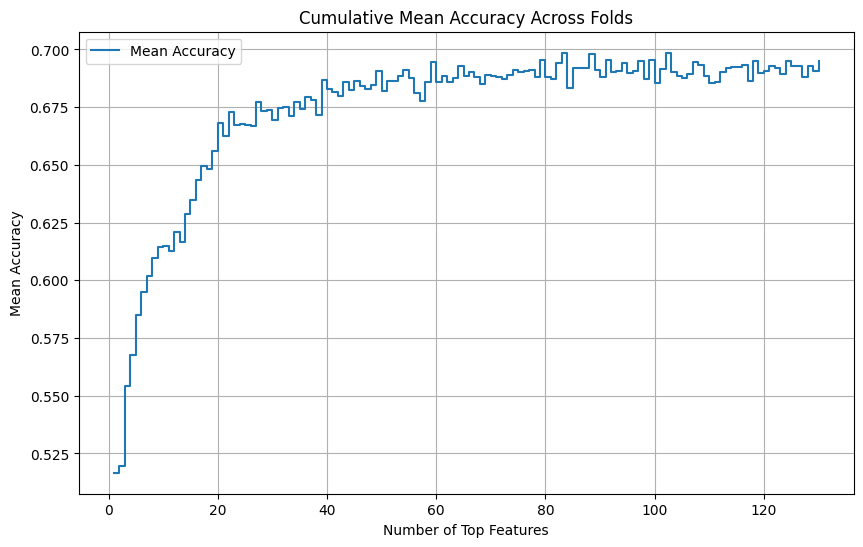

In [10]:
plt.figure(figsize=(10, 6))
plt.step(range(1, max_features + 1), mean_accuracies, where='post', label='Mean Accuracy')
plt.xlabel('Number of Top Features')
plt.ylabel('Mean Accuracy')
plt.title('Cumulative Mean Accuracy Across Folds')
plt.legend()
plt.grid(True)
plt.savefig("step_plot_mi_scores_xgboost.pdf",bbox_inches='tight')

plt.show()
